## **財務演算法作業二**

**FX spot Rate + Swap Point -> 台幣遠期利率** <br>
-> **但不能拿來評價利率衍生品，只能用匯率相關**

summarize重要結論 <br>
重要資訊: 姓名學號系級 <br>
寄到dongmy@ms5.hinet.net <br>

In [286]:
## 市場資料

r1m, r2m, r3m, r6m, r12m = 0.001675, 0.00207,0.0023845,0.0035350,0.005881
fx_spot = 108
sp1m, sp2m, sp3m, sp6m, sp12m = -0.01325, -0.0425, -0.05855, -0.1221, -0.301
y_barrier = 105
n_barrier = 110

fx_6m = fx_spot + sp6m # 6個月的遠期匯率
rf6m = (1+r6m)*fx_spot/fx_6m-1 

In [134]:
## Heston Model 參數

v0 = 0.0102401
kappa = 1.171979
theta = 0.0141483
rho = 0.128199
sigma = 0.336611

True
得到報酬


Text(0.5, 1.0, 'Volatility')

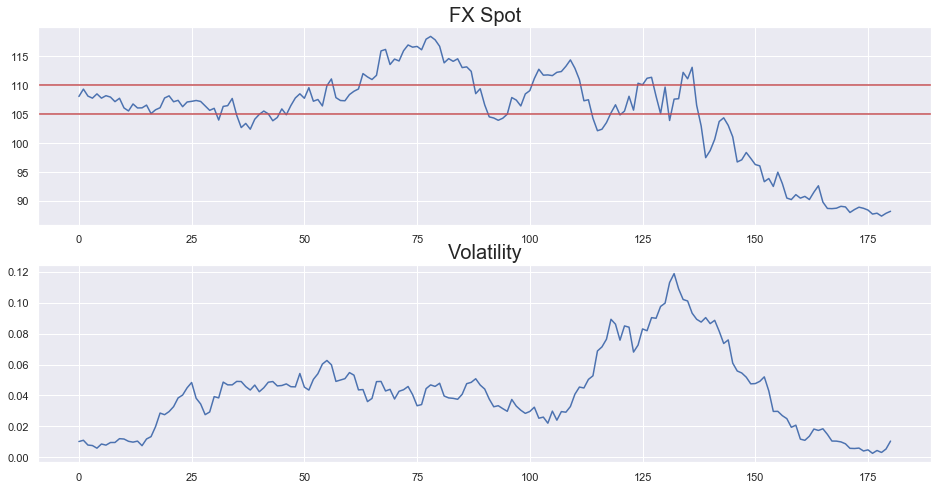

In [337]:
import numpy as np
from math import sqrt, exp, log
zero_cov_rand = np.random.normal(size=(180,2)) #抽零相關的樣本
cov_matrix = np.array([[1,rho],[rho,1]]) #共變異數矩陣
cho_cov = np.linalg.cholesky(cov_matrix) # cholesky
rho_cov_rand = zero_cov_rand.dot(cho_cov.T) #有相關性的brownian motion

S = [fx_spot]
V = [v0]
dt = 1/180
touch_Y = False
touch_N = False
get_payoff = False
for i in range(180):
    dS = (r6m-rf6m)*S[-1]*dt + sqrt(V[-1])*S[-1]*rho_cov_rand[i][0]*sqrt(dt)
    dV = kappa*(theta-V[-1])*dt + sigma*sqrt(V[-1])*rho_cov_rand[i][1]*sqrt(dt)
    if (S[-1]+dS <= y_barrier) & (not touch_N):
        touch_Y = True
    if (S[-1]+dS >= n_barrier) & (not touch_Y):
        touch_N = True
    V.append(abs(V[-1]+dV))
    S.append(S[-1]+dS)
if touch_Y & (not touch_N):
    get_payoff = True
    
print(get_payoff)
if touch_N: 
    print("先碰到N barrier")
elif (not touch_Y): 
        print("沒碰到Y barrier")
else:
    print("得到報酬")
    
plt.figure(figsize=(16,8))
plt.subplot(211)
plt.plot(x,S)
plt.axhline(105, color= 'r')
plt.axhline(110, color= 'r')
plt.title('FX Spot',size=20)
plt.subplot(212)
plt.plot(x,V)
plt.title('Volatility',size=20)

In [338]:
import numpy as np
from math import sqrt, exp, log

# 跑一次monte_carlo得一條路徑，看使否得到報酬
def monte_carlo(r6m,fx_spot,y_barrier,n_barrier,fx_6m,rf6m,v0,kappa,theta,rho,sigma):
    
    ## 抽樣
    zero_cov_rand = np.random.normal(size=(180,2)) #抽零相關的樣本
    cov_matrix = np.array([[1,rho],[rho,1]]) #共變異數矩陣
    cho_cov = np.linalg.cholesky(cov_matrix) # cholesky
    rho_cov_rand = zero_cov_rand.dot(cho_cov.T) #有相關性的brownian motion
    
    ## 模擬 S, V路徑，檢查是否得到報酬
    S = [fx_spot]
    V = [v0]
    dt = 1/180
    touch_Y = False
    touch_N = False
    get_payoff = False
    for i in range(180):
        dS = (r6m-rf6m)*S[-1]*dt + sqrt(V[-1])*S[-1]*rho_cov_rand[i][0]*sqrt(dt)
        dV = kappa*(theta-V[-1])*dt + sigma*sqrt(V[-1])*rho_cov_rand[i][1]*sqrt(dt)
        if (S[-1]+dS <= y_barrier) & (not touch_N):
            touch_Y = True
        if (S[-1]+dS >= n_barrier) & (not touch_Y):
            touch_N = True
        V.append(abs(V[-1]+dV))
        S.append(S[-1]+dS)
    if touch_Y & (not touch_N):
        get_payoff = True
    return get_payoff

In [340]:
monte_carlo(r6m,fx_spot,y_barrier,n_barrier,fx_6m,rf6m,v0,kappa,theta,rho,sigma)

False

In [343]:
result_list = []
for i in range(100000):
    result = monte_carlo(r6m,fx_spot,y_barrier,n_barrier,fx_6m,rf6m,v0,kappa,theta,rho,sigma)
    if result:
        result_list.append(1)
    else:
        result_list.append(0)
    if i % 10000 == 0:
        print("已經模擬{:^8d}次".format(i))

已經模擬   0    次
已經模擬 10000  次
已經模擬 20000  次
已經模擬 30000  次
已經模擬 40000  次
已經模擬 50000  次
已經模擬 60000  次
已經模擬 70000  次
已經模擬 80000  次
已經模擬 90000  次


In [344]:
sum(result_list) / len(result_list)

0.42083